In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse
from alive_progress import alive_bar
import time
import os

# Load the data
train_data = pd.read_parquet("data/train_data.parquet")
test_data = pd.read_parquet("data/test_data.parquet")
# test_data = pd.read_csv("matching/matched/output_callput_full.csv")

# Convert expiry to datetime if it's not already
if train_data["expiry"].dtype != "datetime64[ns]":
    train_data["expiry"] = pd.to_datetime(train_data["expiry"])

# Get the target expiry date
target_date = pd.Timestamp("2025-05-08").date()

In [15]:
data_path = "data"
output_path = "output/"
temp_path = "tmp/"

sample_submission = pd.read_csv(f"{data_path}/sample_submission.csv")
submission_cols = sample_submission.columns.tolist()

In [16]:
# Filter rows with the specified expiry date
expiry_filter = train_data['expiry'].dt.date == target_date
target_rows = train_data[expiry_filter]

# Get indices of rows to be used for validation (50% of the rows with target expiry)
validation_indices = target_rows.sample(frac=0.3, random_state=43).index

# Create validation set
val_data = train_data.loc[validation_indices].copy()

# Remove validation data from training set
train_data = train_data.drop(validation_indices)

# Print shapes to confirm
print(f"Original training data shape: {len(train_data) + len(val_data)}")
print(f"New training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Original training data shape: 178340
New training data shape: (154587, 97)
Validation data shape: (23753, 97)
Test data shape: (12065, 96)


In [17]:
test_data.columns

Index(['timestamp', 'underlying', 'call_iv_24000', 'call_iv_24100',
       'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24500',
       'call_iv_24600', 'call_iv_24700', 'call_iv_24800', 'call_iv_24900',
       'call_iv_25000', 'call_iv_25100', 'call_iv_25200', 'call_iv_25300',
       'call_iv_25400', 'call_iv_25500', 'call_iv_25600', 'call_iv_25700',
       'call_iv_25800', 'call_iv_25900', 'call_iv_26000', 'call_iv_26100',
       'call_iv_26200', 'call_iv_26300', 'call_iv_26400', 'call_iv_26500',
       'put_iv_23000', 'put_iv_23100', 'put_iv_23200', 'put_iv_23300',
       'put_iv_23400', 'put_iv_23500', 'put_iv_23600', 'put_iv_23700',
       'put_iv_23800', 'put_iv_23900', 'put_iv_24000', 'put_iv_24100',
       'put_iv_24200', 'put_iv_24300', 'put_iv_24400', 'put_iv_24500',
       'put_iv_24600', 'put_iv_24700', 'put_iv_24800', 'put_iv_24900',
       'put_iv_25000', 'put_iv_25100', 'put_iv_25200', 'put_iv_25300',
       'put_iv_25400', 'put_iv_25500', 'X0', 'X1', 'X2',

In [18]:
train_data.columns

Index(['timestamp', 'underlying', 'expiry', 'call_iv_23500', 'call_iv_23600',
       'call_iv_23700', 'call_iv_23800', 'call_iv_23900', 'call_iv_24000',
       'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400',
       'call_iv_24500', 'call_iv_24600', 'call_iv_24700', 'call_iv_24800',
       'call_iv_24900', 'call_iv_25000', 'call_iv_25100', 'call_iv_25200',
       'call_iv_25300', 'call_iv_25400', 'call_iv_25500', 'call_iv_25600',
       'call_iv_25700', 'call_iv_25800', 'call_iv_25900', 'call_iv_26000',
       'put_iv_22500', 'put_iv_22600', 'put_iv_22700', 'put_iv_22800',
       'put_iv_22900', 'put_iv_23000', 'put_iv_23100', 'put_iv_23200',
       'put_iv_23300', 'put_iv_23400', 'put_iv_23500', 'put_iv_23600',
       'put_iv_23700', 'put_iv_23800', 'put_iv_23900', 'put_iv_24000',
       'put_iv_24100', 'put_iv_24200', 'put_iv_24300', 'put_iv_24400',
       'put_iv_24500', 'put_iv_24600', 'put_iv_24700', 'put_iv_24800',
       'put_iv_24900', 'put_iv_25000', 'X0', '

In [19]:
pred_cols = list(
    filter(
        lambda x: x.startswith("call") or x.startswith("put"), val_data.columns.tolist()
    )
)
len(pred_cols)

52

## Setting 32 columns to nan randomly in each row

In [20]:
if os.path.exists(f"{temp_path}/sample_val.csv") and os.path.exists(f"{temp_path}/val_Y.csv"):
  # If the sample files already exist, load them
  sample_val = pd.read_csv(f"{temp_path}/sample_val.csv")
  val_Y = pd.read_csv(f"{temp_path}/val_Y.csv")
  print("Loaded existing sample_val and val_Y.")
else:
  # Create a copy of val_data to avoid modifying the original
  sample_val = val_data.copy()

  # Get the call and put columns separately
  call_cols = [col for col in pred_cols if col.startswith('call')]
  put_cols = [col for col in pred_cols if col.startswith('put')]

  # For each row, randomly select 16 call columns and 16 put columns to set to NaN
  for idx in sample_val.index:
    # Randomly select 16 call columns for this row
    nan_call_cols = np.random.choice(call_cols, size=16, replace=False)
    
    # Randomly select 16 put columns for this row
    nan_put_cols = np.random.choice(put_cols, size=16, replace=False)
    
    # Set these columns to NaN for this row
    sample_val.loc[idx, nan_call_cols] = np.nan
    sample_val.loc[idx, nan_put_cols] = np.nan

  # Create val_Y from the original validation data, containing only the target columns
  val_Y = val_data[pred_cols]
  sample_val.to_csv(f"{temp_path}/sample_val.csv", index=False)
  val_Y.to_csv(f"{temp_path}/val_Y.csv", index=False)

Loaded existing sample_val and val_Y.


In [21]:
sample_val

,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,1746590742000000000,24433.0,2025-05-08,0.435793,NaN,NaN,0.35605,0.323607,NaN,NaN,...,-0.022656,0.006262,2.553592e+06,-0.001931,2.372125,0.068108,-1.522534e+06,-3.048516e+06,1.254699e+06,-0.000000e+00
1,1746176782000000000,24285.5,2025-05-08,0.206319,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003836,-0.004734,6.693594e+05,0.010055,1.315715,0.030237,5.235704e+04,-8.124241e+06,1.313372e+06,-1.000000e-06
2,1746520665000000000,24387.5,2025-05-08,NaN,0.270770,NaN,NaN,0.199588,0.173109,NaN,...,0.001037,0.003309,2.847738e+06,0.008796,0.648142,0.041674,3.459928e+05,-2.764208e+07,2.203250e+06,0.000000e+00
3,1746591359000000000,24384.6,2025-05-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.035097,-0.030470,-3.629051e+06,0.146150,-8.941554,1.278703,6.211531e+06,7.623811e+06,-5.587995e+05,3.208558e+06
4,1746165957000000000,24329.3,2025-05-08,0.211074,NaN,0.196625,NaN,0.181550,NaN,NaN,...,0.001900,0.002318,-1.051215e+06,0.026776,0.242156,0.025405,2.716713e+06,-3.698245e+06,-0.000000e+00,-0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39583,1746515731000000000,24393.6,2025-05-08,NaN,0.266833,NaN,NaN,0.199508,NaN,NaN,...,-0.008578,-0.004349,7.608529e+05,0.022286,0.276633,-0.049681,-3.766206e+05,3.310812e+06,0.000000e+00,0.000000e+00
39584,1746609873000000000,24362.1,2025-05-08,0.424743,NaN,0.360815,NaN,NaN,NaN,0.216435,...,0.006081,-0.001241,-5.956005e+06,-0.053984,-2.637237,0.118681,-7.248843e+05,-4.210857e+06,-3.790669e+06,0.000000e+00
39585,1746173465000000000,24415.4,2025-05-08,NaN,NaN,0.197977,NaN,NaN,0.169431,NaN,...,0.016044,0.013809,-1.940570e+05,-0.009913,1.074973,0.016054,-3.876233e+05,4.172262e+06,0.000000e+00,1.000000e-06
39586,1746431799000000000,24450.5,2025-05-08,NaN,0.239076,NaN,NaN,0.190411,NaN,NaN,...,-0.008472,0.003098,3.785463e+05,0.001317,0.374664,0.009704,-6.879767e+06,-6.470817e+06,0.000000e+00,0.000000e+00


In [22]:
sample_val.shape

(39588, 97)

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from tqdm import tqdm
from multiprocess import Pool, cpu_count
from scipy.interpolate import CubicSpline


def fit_cubic_spline_row(args):
    """
    Fit cubic spline on given row and return values for each strike price.

    Parameters: args: tuple - (row, cols, normalize)
    row: pandas Series - row containing IV data
    cols: list - column names for IV values (e.g., call_cols or put_cols)
    normalize: bool - whether to normalize strike prices for better accuracy

    Returns:
    numpy array - fitted IV values for all strike prices
    """
    # imporint again for parallel processing
    import numpy as np
    import pandas as pd
    from scipy.optimize import minimize
    from tqdm import tqdm
    from multiprocess import Pool, cpu_count
    from scipy.interpolate import CubicSpline
    from scipy.interpolate import PchipInterpolator

    row, cols, normalize = args
    ivs = row[cols].values.astype(np.float64)
    strikes = np.array([float(c.split("_")[-1]) for c in cols])

    # Filter out NaN values
    valid = ~np.isnan(ivs)
    if valid.sum() < 3:  # Need at least 3 points for cubic spline
        return ivs

    iv_valid = ivs[valid]
    strikes_valid = strikes[valid]

    # Normalize strikes if requested
    if normalize:
        F = row["underlying"]
        strikes_norm = strikes_valid / F
        strikes_all_norm = strikes / F

        try:
            # Fit cubic spline on normalized strikes
            interpolator = PchipInterpolator(strikes_norm, iv_valid, extrapolate=True)
            iv_fitted =interpolator(strikes)
        except:
            # Fallback to non-normalized if normalization fails
            try:
                interpolator = PchipInterpolator(strikes_norm, iv_valid, extrapolate=True)
                iv_fitted =interpolator(strikes)
            except:
                return ivs
    else:
        try:
            cs = CubicSpline(strikes_valid, iv_valid, bc_type="natural")
            iv_fitted = cs(strikes)
        except:
            return ivs

    # Ensure fitted values are positive (IV cannot be negative)
    iv_fitted = np.maximum(iv_fitted, 0.0001)

    return iv_fitted

In [24]:
call_cols = [col for col in pred_cols if col.startswith('call')]
put_cols = [col for col in pred_cols if col.startswith('put')]

In [25]:
def parallel_fit_spline(df, cols, normalize=True, processes=8, batch_size=500):
    if processes is None:
        processes = max(cpu_count() - 1, 1)
    print("Starting parallel Cubic Spline fitting with", processes, "processes")
    df_filled = df.copy()
    n = len(df)
    for start in tqdm(range(0, n, batch_size), desc="Fitting Cubic Spline"):
        end = min(start + batch_size, n)
        batch = df.iloc[start:end]
        args = [(row, cols, normalize) for _, row in batch.iterrows()]

        with Pool(processes) as pool:
            results = pool.map(fit_cubic_spline_row, args)

        for i, new_ivs in enumerate(results):
            df_filled.iloc[start + i, df.columns.get_indexer(cols)] = new_ivs

    return df_filled

# Prediction based on only testing data

In [26]:
# Define columns with IVs
cols_call = [col for col in sample_val.columns if col.startswith('call')]
cols_put = [col for col in sample_val.columns if col.startswith('put')]

# Apply SVI fitting across full dataset in parallel with progress bar
df_filled = parallel_fit_spline(
    sample_val, cols_call, normalize=True, processes=8, batch_size=200
)
sample_val = df_filled.copy();
df_filled = parallel_fit_spline(
    sample_val, cols_put, normalize=True, processes=8, batch_size=200
)
sample_val = df_filled.copy()
print("Cubic Spline fitting completed.")
print("rmse:", rmse(val_Y, sample_val[pred_cols]))

Starting parallel Cubic Spline fitting with 8 processes


Fitting Cubic Spline: 100%|██████████| 198/198 [07:57<00:00,  2.41s/it]


Starting parallel Cubic Spline fitting with 8 processes


Fitting Cubic Spline: 100%|██████████| 198/198 [06:53<00:00,  2.09s/it]

Cubic Spline fitting completed.
rmse: 3.616398467181377e+16


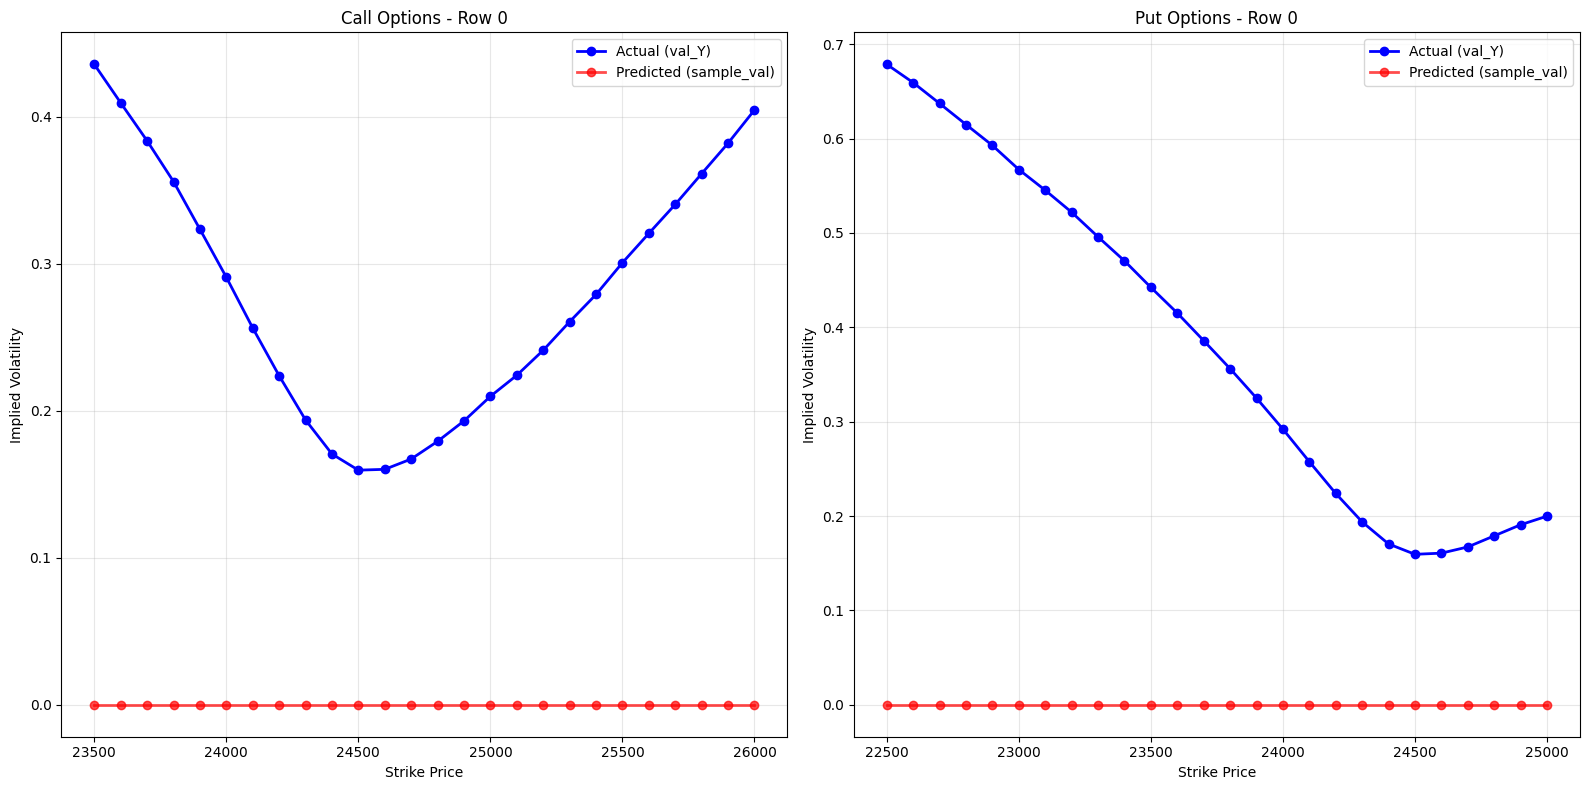

In [27]:
def plot_validation_comparison(row_idx):
  """
  Plot comparison between predicted values (sample_val) and actual values (val_Y) for a specific row
  
  Parameters:
  row_idx (int): The index of the row to plot
  """
  plt.figure(figsize=(16, 8))
  
  # Get call and put columns
  call_cols = [col for col in pred_cols if col.startswith('call')]
  put_cols = [col for col in pred_cols if col.startswith('put')]
  
  # Extract strike prices
  call_strikes = np.array([float(col.split('_')[-1]) for col in call_cols])
  put_strikes = np.array([float(col.split('_')[-1]) for col in put_cols])
  
  # Plot call options
  plt.subplot(1, 2, 1)
  plt.plot(call_strikes, val_Y.iloc[row_idx][call_cols], 'bo-', label='Actual (val_Y)', linewidth=2, markersize=6)
  plt.plot(call_strikes, sample_val.iloc[row_idx][call_cols], 'ro-', label='Predicted (sample_val)', linewidth=2, markersize=6, alpha=0.7)
  plt.title(f'Call Options - Row {row_idx}')
  plt.xlabel('Strike Price')
  plt.ylabel('Implied Volatility')
  plt.legend()
  plt.grid(True, alpha=0.3)
  
  # Plot put options
  plt.subplot(1, 2, 2)
  plt.plot(put_strikes, val_Y.iloc[row_idx][put_cols], 'bo-', label='Actual (val_Y)', linewidth=2, markersize=6)
  plt.plot(put_strikes, sample_val.iloc[row_idx][put_cols], 'ro-', label='Predicted (sample_val)', linewidth=2, markersize=6, alpha=0.7)
  plt.title(f'Put Options - Row {row_idx}')
  plt.xlabel('Strike Price')
  plt.ylabel('Implied Volatility')
  plt.legend()
  plt.grid(True, alpha=0.3)
  
  plt.tight_layout()
  plt.show()

# Plot comparison for a specific row
plot_validation_comparison(0)

In [28]:
sample_val[call_cols].isna().sum().sum()

0

In [29]:
final_test_cols = list(
    filter(
        lambda x: x.startswith("call") or x.startswith("put"), test_data.columns.tolist()
    )
)
len(final_test_cols)

52

In [30]:
test_data[final_test_cols].isna().sum().sum()

376504

In [31]:
cols_call = [col for col in test_data.columns if col.startswith("call")]
cols_put = [col for col in test_data.columns if col.startswith("put")]


# Apply SVI fitting across full dataset in parallel with progress bar
df_filled = parallel_fit_spline(test_data, cols_call, normalize=True, processes=8, batch_size=200)
test_data = df_filled.copy()
df_filled = parallel_fit_spline(test_data, cols_put, normalize=True, processes=8, batch_size=200)
test_data = df_filled.copy()

Starting parallel Cubic Spline fitting with 8 processes


Fitting Cubic Spline:   3%|▎         | 2/61 [00:05<02:42,  2.75s/it]


KeyboardInterrupt: 

In [ ]:
test_data.isna().sum().sum()

0

In [ ]:
test_data.isna().sum().sum()

0

In [ ]:
filled_val_data = test_data.copy()

In [ ]:
# # filling remaining 122 nan values (< 3 valid cols)
# for col in final_test_cols:
#     test_df_col = filled_val_data[col].copy()
#     test_df_col.dropna(inplace=True)
#     median = test_df_col.median()
#     # print(median)
#     filled_val_data[col] = filled_val_data[col].fillna(median)
# filled_val_data.isna().sum().sum()

In [ ]:
test_data = filled_val_data.copy()

In [ ]:
cubic_submission = filled_val_data[submission_cols]
cubic_submission.to_csv(f"{output_path}/cubic_submission.csv", index=False)
cubic_submission

,timestamp,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,0,0.280939,0.250310,0.256569,0.251509,0.242149,0.239826,0.232439,0.227128,0.222997,...,0.232334,0.226005,0.222937,0.227301,0.234169,0.245671,0.250422,0.259548,0.274226,0.282229
1,1,0.270276,0.272136,0.258893,0.250142,0.243810,0.238194,0.233548,0.228239,0.225751,...,0.234276,0.228209,0.225580,0.230905,0.238673,0.249402,0.258352,0.264555,0.273292,0.281367
2,2,0.254930,0.251731,0.235451,0.224953,0.214869,0.204580,0.194604,0.187288,0.182759,...,0.194612,0.188052,0.182910,0.181115,0.181346,0.185434,0.190750,0.196949,0.204845,0.212567
3,3,0.241888,0.232762,0.220505,0.209550,0.198602,0.186190,0.173789,0.166457,0.160899,...,0.173325,0.166394,0.161561,0.159978,0.164384,0.172032,0.185666,0.193982,0.196568,0.206107
4,4,0.235328,0.230199,0.222983,0.214126,0.207052,0.199081,0.192603,0.187101,0.182540,...,0.193152,0.186880,0.182283,0.177920,0.176293,0.176000,0.177743,0.179256,0.182314,0.185864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12060,12060,0.243032,0.233427,0.225079,0.215693,0.206724,0.199590,0.192518,0.186856,0.180756,...,0.192817,0.186377,0.181771,0.177270,0.175222,0.174754,0.176356,0.177716,0.178742,0.182071
12061,12061,0.240958,0.236380,0.226972,0.217036,0.209518,0.200906,0.193655,0.187692,0.183264,...,0.193841,0.187603,0.183401,0.180196,0.177969,0.177923,0.178943,0.180254,0.181694,0.183994
12062,12062,0.256475,0.243817,0.234267,0.221270,0.211873,0.201654,0.192601,0.185088,0.179760,...,0.192306,0.184818,0.179666,0.176916,0.177109,0.180643,0.186710,0.192324,0.201360,0.209940
12063,12063,0.250470,0.239825,0.231511,0.223196,0.211570,0.206038,0.198442,0.190833,0.185851,...,0.197971,0.190933,0.186172,0.182287,0.178045,0.177690,0.178552,0.178806,0.180169,0.182406


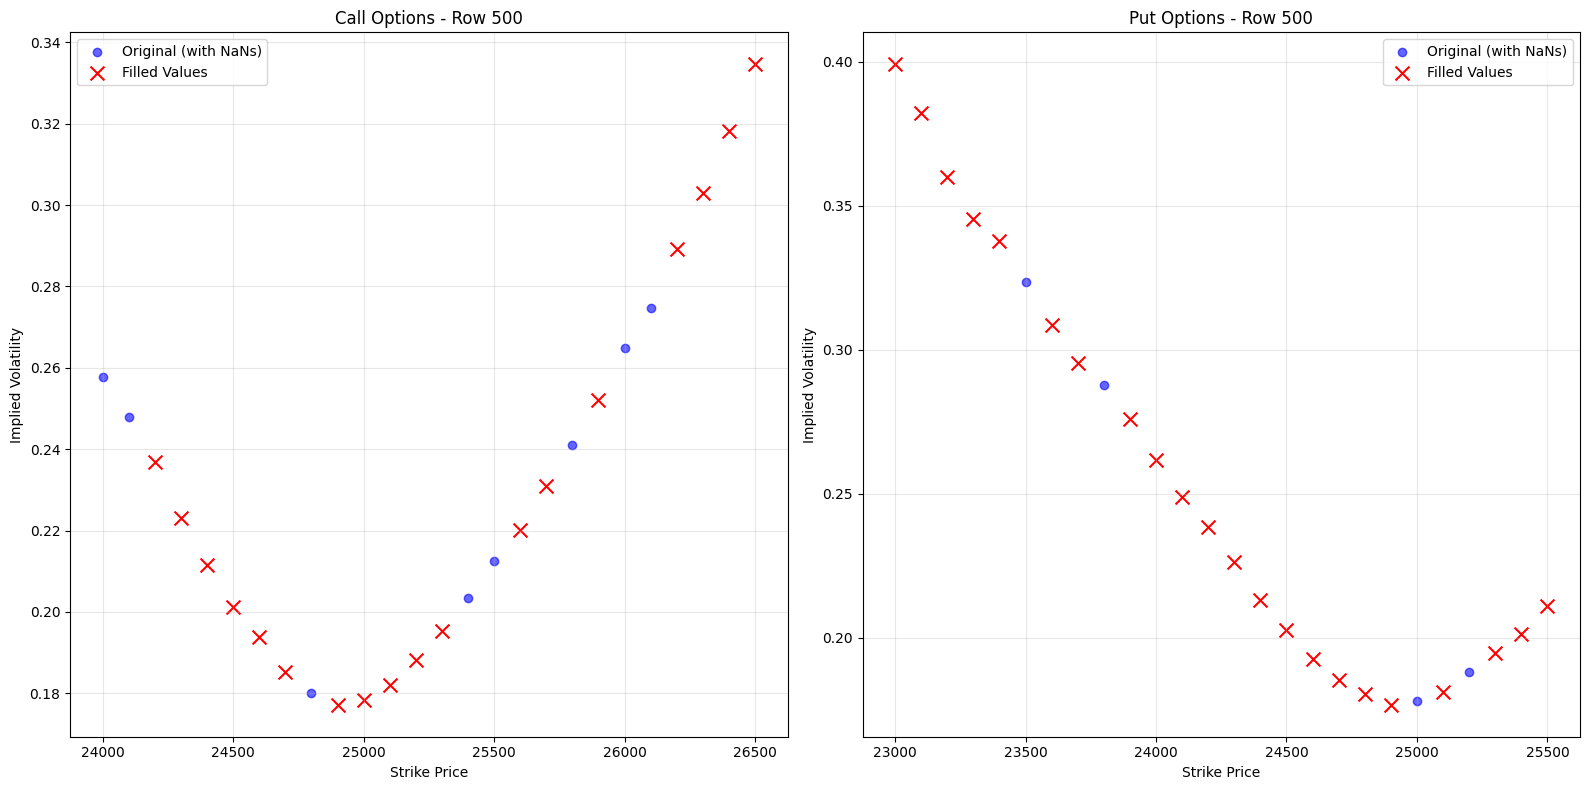

In [ ]:
# Load test data into another variable for comparison
original_test_data = pd.read_parquet("data/test_data.parquet")


def compare_predictions(row_idx, data_type=["call", "put"]):
    """
    Draw a graph comparing original test data with filled data for a specific row

    Parameters:
    row_idx (int): The index of the row to plot
    data_type (list): Types of options to plot - "call", "put", or both
    """
    plt.figure(figsize=(16, 8))

    if "call" in data_type:
        call_cols = [col for col in final_test_cols if col.startswith("call")]
        call_strikes = np.array([float(col.split("_")[-1]) for col in call_cols])

        plt.subplot(1, 2, 1)
        # Original data with NaNs
        plt.scatter(
            call_strikes,
            original_test_data.loc[row_idx, call_cols],
            color="blue",
            label="Original (with NaNs)",
            alpha=0.6,
        )

        # Plot NaN points differently
        nan_mask = original_test_data.loc[row_idx, call_cols].isna()
        plt.scatter(
            call_strikes[nan_mask],
            test_data.loc[row_idx, call_cols].values[nan_mask],
            color="red",
            marker="x",
            s=100,
            label="Filled Values",
        )

        plt.title("Call Options - Row {}".format(row_idx))
        plt.xlabel("Strike Price")
        plt.ylabel("Implied Volatility")
        plt.legend()
        plt.grid(True, alpha=0.3)

    if "put" in data_type:
        put_cols = [col for col in final_test_cols if col.startswith("put")]
        put_strikes = np.array([float(col.split("_")[-1]) for col in put_cols])

        plt.subplot(1, 2, 2)
        # Original data with NaNs
        plt.scatter(
            put_strikes,
            original_test_data.loc[row_idx, put_cols],
            color="blue",
            label="Original (with NaNs)",
            alpha=0.6,
        )

        # Plot NaN points differently
        nan_mask = original_test_data.loc[row_idx, put_cols].isna()
        plt.scatter(
            put_strikes[nan_mask],
            test_data.loc[row_idx, put_cols].values[nan_mask],
            color="red",
            marker="x",
            s=100,
            label="Filled Values",
        )

        plt.title("Put Options - Row {}".format(row_idx))
        plt.xlabel("Strike Price")
        plt.ylabel("Implied Volatility")
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Find a row with some NaN values to demonstrate

compare_predictions(500)